[INFO] Using font: Times New Roman
[INFO] Registered font files: ['times.ttf', 'timesbd.ttf', 'timesi.ttf', 'timesbi.ttf']


/tmp/ipykernel_1473/888953664.py:180: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  usa_geom = usa.geometry.unary_union


[INFO] basins within CONUS: 671


/tmp/ipykernel_1473/888953664.py:198: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = gdf.geometry.unary_union.intersection(conus_geom)
/tmp/ipykernel_1473/888953664.py:198: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = gdf.geometry.unary_union.intersection(conus_geom)
/tmp/ipykernel_1473/888953664.py:198: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = gdf.geometry.unary_union.intersection(conus_geom)
/tmp/ipykernel_1473/888953664.py:198: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = gdf.geometry.unary_union.intersection(conus_geom)
/tmp/ipykernel_1473/888953664.py:198: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = gdf.geometry.unary_union.intersection(conus_geom)
/tmp/ipyke

[INFO] loaded subregions: 17
[INFO] Using manual counts from your figure:
  - NorthAtlantic: 53
  - MidAtlantic: 44
  - Appalachia: 66
  - Southeast: 38
  - DeepSouth: 30
  - Prairie: 51
  - GreatLakes: 24
  - NPlains: 19
  - NRockies: 18
  - SRockies: 30
  - CPlains: 6
  - SPlains: 30
  - Southwest: 12
  - GreatBasin: 12
  - PacificSW: 15
  - PacificNW: 62
  - Mezquital: 1
Saved: /mnt/d/desktop/paper_data/01/paper_output/camels_subregions_basins_counts.png


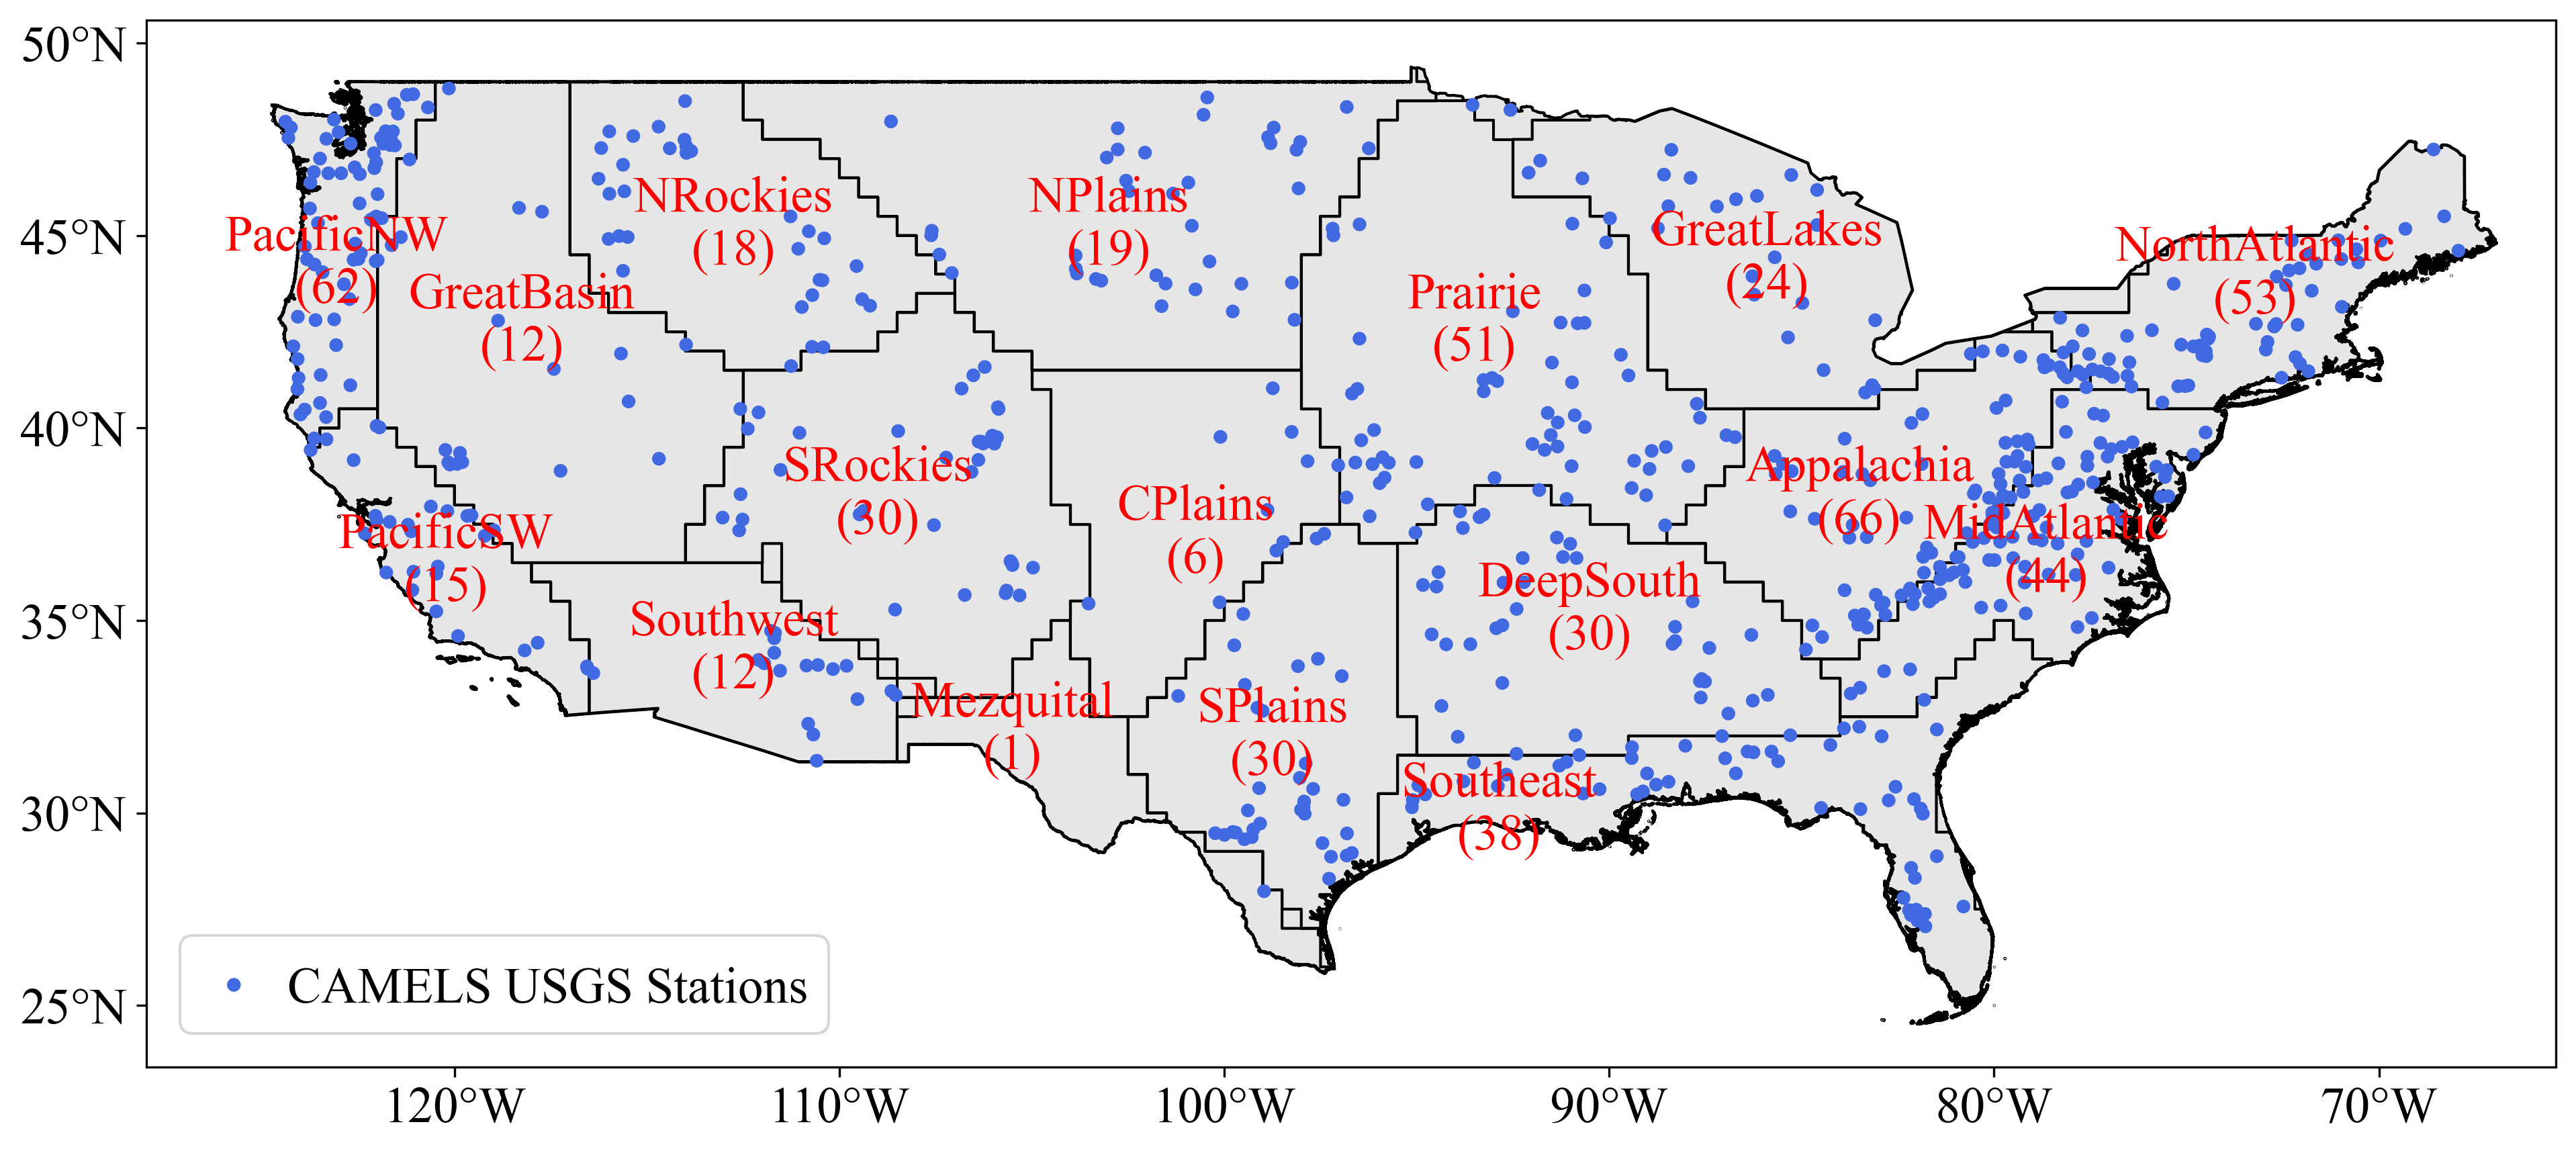

[DONE]


In [ ]:
#fig.1#
"""
CAMELS basins + subregions overview map (NO skill/NSE/KGE)
- Blue dots: CAMELS USGS Stations (from camels_topo.txt)
- Subregion boundaries: from <REGION_SHPS_DIR>/<name>.shp (intersected with CONUS geometry)
- Red label: "<SubregionName> (N)" where N is MANUALLY provided (read from your reference figure)
- Adds lat/lon ticks (no gridlines)

Output:
  <OUT_DIR>/camels_subregions_basins_counts.png
"""

import os
from pathlib import Path

import pandas as pd
import geopandas as gpd
from shapely.geometry import box

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# ===================== 0) Font: Times New Roman (Windows Fonts) =====================

FONT_DIR = Path("/mnt/c/Windows/Fonts") 

def setup_times_new_roman(font_dir: Path):
    """
    Register Times New Roman from Windows font directory and force matplotlib to use it everywhere.
    Tries common Windows TNR filenames:
      times.ttf, timesbd.ttf, timesi.ttf, timesbi.ttf
    """
    if not font_dir.exists():
        raise FileNotFoundError(f"FONT_DIR not found: {font_dir}")

    # Windows 
    candidates = [
        font_dir / "times.ttf",    # Regular
        font_dir / "timesbd.ttf",  # Bold
        font_dir / "timesi.ttf",   # Italic
        font_dir / "timesbi.ttf",  # Bold Italic
    ]
    existing = [p for p in candidates if p.exists()]

    if not existing:
       
        fallback = []
        for ext in ("*.ttf", "*.otf", "*.ttc"):
            fallback.extend(list(font_dir.glob(ext)))
        fallback = [p for p in fallback if "times" in p.name.lower()]
        existing = fallback

    if not existing:
        raise RuntimeError(f"No Times New Roman font files found under: {font_dir}")

 
    for fp in existing:
        try:
            fm.fontManager.addfont(str(fp))
        except Exception as e:
            print(f"[WARN] failed to add font {fp}: {e}")


    regular = candidates[0] if candidates[0].exists() else existing[0]
    tnr_prop = fm.FontProperties(fname=str(regular))
    tnr_name = tnr_prop.get_name()  


    mpl.rcParams["font.family"] = tnr_name
    mpl.rcParams["font.sans-serif"] = [tnr_name] 
    mpl.rcParams["axes.unicode_minus"] = False

    mpl.rcParams["mathtext.fontset"] = "custom"
    mpl.rcParams["mathtext.rm"] = tnr_name
    mpl.rcParams["mathtext.it"] = f"{tnr_name}:italic"
    mpl.rcParams["mathtext.bf"] = f"{tnr_name}:bold"

    print(f"[INFO] Using font: {tnr_name}")
    print(f"[INFO] Registered font files: {[p.name for p in existing]}")
    return tnr_prop, tnr_name



TNR_PROP, TNR_NAME = setup_times_new_roman(FONT_DIR)


# ===================== 1) config =====================

# topo (gauge_id / gauge_lat / gauge_lon)
CAMELS_TOPO = "/mnt/d/desktop/paper_data/01/static_attri/camels_topo.txt"

# 
REGION_SHPS_DIR = "/mnt/d/desktop/paper_data/01/shp_outputs"

SUBREGION_NAMES = [
    "NorthAtlantic", "MidAtlantic", "Appalachia", "Southeast", "DeepSouth",
    "Prairie", "GreatLakes", "NPlains", "NRockies", "SRockies",
    "CPlains", "SPlains", "Southwest", "GreatBasin", "PacificSW", "PacificNW",
    "Mezquital"
]


SUBREGION_COUNTS = {
    "PacificNW": 62,
    "PacificSW": 15,
    "GreatBasin": 12,
    "Southwest": 12,
    "NRockies": 18,
    "SRockies": 30,
    "NPlains": 19,
    "CPlains": 6,
    "SPlains": 30,
    "Prairie": 51,
    "GreatLakes": 24,
    "Appalachia": 66,
    "MidAtlantic": 44,
    "NorthAtlantic": 53,
    "DeepSouth": 30,
    "Southeast": 38,
    "Mezquital": 1,
}


USA_SHP = "/mnt/d/desktop/paper_data/01/gadm41_USA_shp/gadm41_USA_0.shp"


US_EXTENT = [-127, -66, 24, 50]  # [lon_min, lon_max, lat_min, lat_max]


OUT_DIR = "/mnt/d/desktop/paper_data/01/paper_output"
os.makedirs(OUT_DIR, exist_ok=True)


POINT_SIZE = 24
POINT_COLOR = "royalblue"  
POINT_LABEL = "CAMELS USGS Stations"

LABEL_COLOR = "red"
LABEL_FONTSIZE = 18

CONUS_FACE = "0.90"
CONUS_EDGE = "black"
CONUS_LW = 1.0

SUBREG_EDGE = "black"
SUBREG_LW = 1.0


plt.rcParams.update({
    "font.size": 18,
    "figure.dpi": 300,
})


# ===================== 2) topo =====================
def read_camels_topo(path: str) -> gpd.GeoDataFrame:
    topo = pd.read_csv(path, sep=r"\s+|,|;", engine="python")
    required = {"gauge_id", "gauge_lat", "gauge_lon"}
    miss = required - set(topo.columns)
    if miss:
        raise ValueError(f"Topo missing columns: {sorted(list(miss))}")

    gdf = gpd.GeoDataFrame(
        topo.copy(),
        geometry=gpd.points_from_xy(topo["gauge_lon"], topo["gauge_lat"]),
        crs="EPSG:4326",
    )
    return gdf


# ===================== 3) USA CONUS geometry =====================
def load_conus_geometry(usa_shp: str, extent):
    usa = gpd.read_file(usa_shp).to_crs("EPSG:4326")
    usa_geom = usa.geometry.unary_union
    bbox = box(extent[0], extent[2], extent[1], extent[3])
    conus = usa_geom.intersection(bbox)
    if conus.is_empty:
        raise RuntimeError("CONUS geometry is empty after intersection. Check USA_SHP and US_EXTENT.")
    return conus


# ===================== 4) subregion =====================
def load_subregions(shp_dir: str, names: list, conus_geom):
    out = []
    for name in names:
        shp = Path(shp_dir) / f"{name}.shp"
        if not shp.exists():
            print(f"[WARN] missing subregion shp: {shp}")
            continue

        gdf = gpd.read_file(shp).to_crs("EPSG:4326")
        geom = gdf.geometry.unary_union.intersection(conus_geom)

        if geom.is_empty:
            print(f"[INFO] {name}: intersection with CONUS is empty -> skip")
            continue

        out.append({"name": name, "geom": geom})
    print(f"[INFO] loaded subregions: {len(out)}")
    return out


# ===================== 5) plot =====================
def plot_map(conus_geom, sub_geoms, basins_gdf, out_dir: str):
    fig = plt.figure(figsize=(13, 6.5), dpi=300)
    ax = fig.add_axes([0.04, 0.08, 0.92, 0.86], projection=ccrs.PlateCarree())

    # extent (extra padding)
    lon_min, lon_max, lat_min, lat_max = US_EXTENT
    pad_left  = 1.0
    pad_right = 0.6
    pad_down  = 0.6
    pad_up    = 0.6

    ax.set_extent(
        [lon_min - pad_left, lon_max + pad_right, lat_min - pad_down, lat_max + pad_up],
        crs=ccrs.PlateCarree()
    )

    # USA outline (gray background)
    ax.add_geometries(
        [conus_geom],
        crs=ccrs.PlateCarree(),
        facecolor=CONUS_FACE,
        edgecolor=CONUS_EDGE,
        linewidth=CONUS_LW,
        zorder=1,
    )

    # subregion boundaries
    for sg in sub_geoms:
        ax.add_geometries(
            [sg["geom"]],
            crs=ccrs.PlateCarree(),
            facecolor="none",
            edgecolor=SUBREG_EDGE,
            linewidth=SUBREG_LW,
            zorder=2,
        )

    # basins (blue dots)
    ax.scatter(
        basins_gdf.geometry.x.values,
        basins_gdf.geometry.y.values,
        s=POINT_SIZE,
        c=POINT_COLOR,
        edgecolor="none",
        zorder=3,
        label=POINT_LABEL,
    )

    # labels (manual counts) - red
    for sg in sub_geoms:
        name = sg["name"]
        if name not in SUBREGION_COUNTS:
            continue

        rp = sg["geom"].representative_point()
        ax.text(
            rp.x, rp.y,
            f"{name}\n({SUBREGION_COUNTS[name]})",
            transform=ccrs.PlateCarree(),
            color=LABEL_COLOR,
            fontsize=LABEL_FONTSIZE,
            ha="center",
            va="center",
            fontweight="bold",
            fontproperties=TNR_PROP,   
            zorder=10,
        )

    # ---------- Lat/Lon ticks WITHOUT gridlines ----------
    xticks = [-120, -110, -100, -90, -80, -70]
    yticks = [25, 30, 35, 40, 45, 50]

    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())

    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=False))
    ax.yaxis.set_major_formatter(LatitudeFormatter())

    ax.tick_params(axis="both", labelsize=30)


    for lab in ax.get_xticklabels() + ax.get_yticklabels():
        lab.set_fontproperties(TNR_PROP)


    # leg = ax.legend(loc="lower left", frameon=True, prop=TNR_PROP)
    leg = ax.legend(
    loc="lower left",
    frameon=True,
    prop=fm.FontProperties(fname=str(FONT_DIR / "times.ttf"), size=24),


    handletextpad=0.3,   
    borderpad=0.3,       
    labelspacing=0.2,    
    handlelength=1.0,    
    markerscale=1.0      
)
    if leg is not None:
        for text in leg.get_texts():
            text.set_fontproperties(TNR_PROP)

    out_png = os.path.join(out_dir, "camels_subregions_basins_counts.png")
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    print("Saved:", out_png)
    plt.show()


# ===================== 6) main =====================
def main():
    basins = read_camels_topo(CAMELS_TOPO)

    conus_geom = load_conus_geometry(USA_SHP, US_EXTENT)

    # keep only basins within conus geometry
    basins = basins[basins.geometry.intersects(conus_geom)].copy()
    print(f"[INFO] basins within CONUS: {len(basins)}")

    sub_geoms = load_subregions(REGION_SHPS_DIR, SUBREGION_NAMES, conus_geom)

    # sanity print
    print("[INFO] Using manual counts from your figure:")
    for n in SUBREGION_NAMES:
        if n in SUBREGION_COUNTS:
            print(f"  - {n}: {SUBREGION_COUNTS[n]}")
        else:
            print(f"  - {n}: (missing in SUBREGION_COUNTS)")

    plot_map(conus_geom, sub_geoms, basins, OUT_DIR)
    print("[DONE]")


if __name__ == "__main__":
    main()
